# Model Predictive Control (MPC) for Autonomous Vehicle Control

## 1. The Problem: 
In autonomous vehicle systems, motion control is typically managed through a hierarchical set of algorithms. At the base of this hierarchy is often a low-level controller, which receives input in the form of a local trajectory or path for the vehicle to follow, as well as data about the surrounding environment, such as obstacles and lane lines. The role of the low-level controller is to generate control signals that can be directly used by the vehicle's hardware to manage motion and steering.

Model Predictive Control (MPC) is a widely adopted, optimization-based control strategy for vehicle trajectory following. Its popularity stems from its ability to handle multi-variable control problems while incorporating both hard constraints (e.g., collision avoidance) and soft constraints (e.g., comfort or efficiency criteria).

This project aims to develop a simplified MPC model to explore its potential for autonomous vehicle control. The primary goal is to evaluate how well the model can enable a simulated vehicle to follow a reference trajectory while avoiding static obstacles.

## 2. Modeling Approach

### 2.1 Kinematic Bicycle Model

We employ the 2D kinematic bicycle model, a widely-used simplified representation of vehicle dynamics that captures essential motion characteristics while maintaining computational efficiency.

- Reference Point: The center of the rear axle serves as the model's reference point.
- Dimensionality: Motion is constrained to a 2D plane.
- Assume negligible slip angle

### 2.2 State Representation

The vehicle state is defined by the vector $\mathbf{x} = [x_x, x_y, x_\psi, x_v]^T$, where:

- $x_x$: X-coordinate in the local frame (m)
- $x_y$: Y-coordinate in the local frame (m)
- $x_\psi$: Vehicle heading angle (radians)
- $x_v$: Vehicle longitudinal velocity (m/s)

### 2.3 Control Variables

Control variables are represented by the vector $\mathbf{u} = [u_a, u_\delta]^T$, where:

- $u_a$: Longitudinal acceleration (m/s²)
- $u_\delta$: Steering angle (radians)

### 2.4 Time Discretization
The continuous-time model is discretized over a finite prediction horizon $N$ using a fixed time step $dt = 0.1s$.

### 2.5. System Constraints

To ensure realistic and physically achievable vehicle motion, we impose the following constraints:

1. Velocity Limits: $0 \leq x_{v,t} \leq 10$ m/s
2. Steering Angle Limits: $-\frac{\pi}{4} \leq u_{\delta,t} \leq \frac{\pi}{4}$ rad
4. Acceleration Limits: $-3 \leq u_{a,t} \leq 3$ m/s²

### 2.6. Kinematic Equations

#### 2.6.1 State Dynamics

The evolution of the vehicle state is governed by the following discrete-time equations:

- ##### Position Update
$$x_{x,t+1} = x_{x,t} + x_{v,t} \cos(x_{\psi,t}) \cdot dt$$
$$x_{y,t+1} = x_{y,t} + x_{v,t} \sin(x_{\psi,t}) \cdot dt$$

- ##### Heading Update
$$x_{\psi,t+1} = x_{\psi,t} + \frac{x_{v,t} \tan(u_{\delta,t})}{L} \cdot dt$$

- ##### Velocity Update
$$x_{v,t+1} = x_{v,t} + u_{a,t} \cdot dt$$

Where:
- $L$: Wheelbase length (m)
- $dt$: Time step (s)

### 2.8. Obstacle Avoidance

The obstacle avoidance constraint is defined by

$$(x_{x,t} - obs_{x})^2 + (x_{y,t} - obs_{y})^2 \geq (obs_{r} + safety\_margin)^2 - s\_obs_{obs, t}\ \ \forall t$$

Where
- $obs_{x}$, $obs_{y}$: Obstacle center coordinates
- $obs_{r}$: Obstacle radius
- $s\_obs_{obs,t}$: Obstacle avoidance slack variable (for robustness)

### 2.9. Objective

The control objective is to minimize a weighted sum of tracking errors and control effort penalties over the prediction horizon.

#### 2.9.1 State Error Penalties
- ##### X Position Error: 
$$Q_x(x_{x,t} - x\_ref_{x,t})^2$$
- ##### Y Position Error: 
$$Q_y(x_{y,t} - x\_ref_{y,t})^2$$
- ##### Heading Error: 
$$Q_{\psi}(x_{\psi,t} - x\_ref_{\psi,t})^2$$
- ##### Velocity Error: 
$$Q_{v}(x_{v,t} - x\_ref_{v,t})^2$$
- ##### Terminal X Position Error:
$$F_x(x_{x,N-1} - x\_ref_{x,N-1})^2$$
- ##### Terminal Y Position Error:
$$F_y(x_{y,N-1} - x\_ref_{y,N-1})^2$$
- ##### Terminal Heading Error:
$$F_{\psi}(x_{\psi,N-1} - x\_ref_{\psi,N-1})^2$$
- ##### Terminal Velocity Error:
$$F_{v}(x_{v,N-1} - x\_ref_{v,N-1})^2$$

#### 2.9.2 Control Effort Penalties
- ##### Steering Angle: 
$$R_{\delta}\delta_t^2$$
- ##### Acceleration: 
$$R_{a}a_t^2$$

#### 2.9.3 Constraint Violation Penalties
$$Os\_obs_{obs, t}$$

### 2.12. Optimization Problem

The MPC problem is formulated as a constrained optimization problem with the following structure:
$$\begin{align*}
\min J = \sum_{t=0}^{N-1} \Big[ &
\sum_{i \in {x,y,\psi,v}} Q_{i}(x_{i,t} - x\_ref_{i,t})^2 +
\sum_{j \in {a,\delta}} R_{j}(u_{j,t})^2 +
\sum_{obs \in obstacles} Os\_obs_{obs, t}
\Big] + \sum_{i \in {x,y,\psi,v}} F_{i}(x_{i,N-1} - x\_ref_{i,N-1})^2
\end{align*}$$

$$\begin{align*}
\text{subject to:} \\
& x_{x,t+1} = x_{x,t} + x_{v,t} \cos(x_{\psi,t}) \cdot dt \\
& x_{y,t+1} = x_{y,t} + x_{v,t} \sin(x_{\psi,t}) \cdot dt \\
& x_{\psi,t+1} = x_{\psi,t} + \frac{x_{v,t} \tan(u_{\delta,t})}{L} \cdot dt \\
& x_{v,t+1} = x_{v,t} + u_{a,t} \cdot dt \\
& (x_{x,t} - obs_{x})^2 + (x_{y,t} - obs_{y})^2 \geq (obs_{r} + safety\_margin)^2 - s\_obs_{obs, t} \\
& 0 \leq x_{v,t} \leq 10 \\
& -\frac{\pi}{4} \leq u_{\delta,t} \leq \frac{\pi}{4} \\
& -3 \leq u_{a,t} \leq 3 \\
& x_{x,0} = x\_init_{x} \\
& x_{y,0} = x\_init_{y} \\
& x_{\psi,0} = x\_init_{\psi} \\
& x_{v,0} = x\_init_{v} \\
& s\_obs_{obs, t} \geq 0
\end{align*}$$

Where
- $Q_x, Q_y, Q_\psi, Q_v$ are the tracking error weights
- $R_a, R_\delta$ are the control effort weights
- $F_x, F_y, F_\psi, F_v$ are the terminal tracking error weights
- $O$ is the obstacle violation weight
- $x\_ref_x, x\_ref_y, x\_ref_\psi, x\_ref_v$ are the reference trajectory values
- $x\_init_x, x\_init_y, x\_init_\psi, x\_init_v$ are the initial state values

Alternatively, $J$ can be written as:

$$\begin{align*}
J = \sum_{t=0}^{N-1} \Big[ & Q_x (x_{x,t} - x_{ref,x,t})^2 + Q_y (x_{y,t} - x_{ref,y,t})^2 + Q_\psi (x_{\psi,t} - x_{ref,\psi,t})^2 \\
& + Q_v (x_{v,t} - x_{ref,v,t})^2 + R_\delta u_{\delta,t}^2 + R_a u_{a,t}^2 + \sum_{obs \in obstacles} Os\_obs_{obs, t} \Big] \\
& + F_{x}(x_{x,N-1} - x\_ref_{x,N-1})^2 + F_{y}(x_{y,N-1} - x\_ref_{y,N-1})^2 \\
& + F_{\psi}(x_{\psi,N-1} - x\_ref_{\psi,N-1})^2 + F_{v}(x_{v,N-1} - x\_ref_{v,N-1})^2
\end{align*}$$

### 2.13. Simulation Approach
In MPC, the optimization problem is solved for the current state up to a prediction horizon $N$. The first control input is applied to the system, and the current state is updated based on the system dynamics. The optimization problem is then solved again for the updated state, and the process is repeated. This iterative process continues for the duration of the simulation. We will implement this simulation approach in the following sections. First, we will only solve the optimization problem for a single time step to understand the MPC formulation and how it predicts the vehicle's trajectory will evolve over the prediction horizon. Then we'll actually implement the receding horizon control loop to simulate the vehicle's motion.

## 3. GAMSPy Formulation
We'll first install dependencies with pip, import pandas, numpy, and gamspy for the model. We'll also use matplotlib so we can create some plots and visualize the vehicle's motion

In [ ]:
! pip install numpy pandas gamspy matplotlib

In [1]:
import sys
import numpy as np
import gamspy as gp
import gamspy.math as gpm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

We first create the base model that we'll reuse many times.  

Here, we also decide how to weight each of our state errors and control actions. Of note, we penalize deviations from reference path velocity and heading less than position deviations since it's more improtant that we stick to the prescribed trajectory waypoints. We also penalize steering more than longitudinal acceleration.

In [2]:
m = gp.Container()

# -------------------------------------------------- Sets --------------------------------------------------
# Time sets
gp_t = gp.Set(m, "t", description="prediction horizon steps")
lastT = gp.Set(m, "lastT", domain=gp_t, is_singleton=True, description="last t")
firstT = gp.Set(m, "firstT", domain=gp_t, is_singleton=True, description="first t")

# State and control sets
state_vars = gp.Set(m, "state_vars", records=['x', 'y', 'psi', 'v'], description="state variables")
control_vars = gp.Set(m, "control_vars", records=['a', 'delta'], description="control variables")

# Obstacle and obstacle metadata sets
gp_obs = gp.Set(m, "obs", description="obstacles")
xyr = gp.Set(m, "xyr", records=['x', 'y', 'r'], description="metadata about obstacles")

# ----------------------------------------------- Parameters -----------------------------------------------
# Simulation parameters
gp_N = gp.Parameter(m, "N", description="prediction horizon length")
dt = gp.Parameter(m, "dt", records=0.1, description="time step")

# Vehicle and control parameters 
L = gp.Parameter(m, "L", records=2.7, description="wheelbase")
v_max = gp.Parameter(m, "v_max", records=10.0, description="max velocity")
a_max = gp.Parameter(m, "a_max", records=3.0, description="max acceleration")
delta_max = gp.Parameter(m, "delta_max", records=np.pi/4, description="max steering angle")

# Obstacle data and parameters
obsData = gp.Parameter(m, 'obsData', domain=[gp_obs, xyr], description="obstacle data")
safety_margin = gp.Parameter(m, "safety_margin", records=0.5, description="obstacle safety margin")

# Initial state parameters
x_init = gp.Parameter(m, "x_init", domain=state_vars, description="initial state")

# Reference trajectory
x_ref = gp.Parameter(m, "x_ref", domain=[gp_t, state_vars])

# Cost vectors
Q = gp.Parameter(m, 'Q', domain=state_vars, description='state weight vector',
    records=np.array([2.0, 2.0, 2.0, 1.0]))  # x, y, psi, v weights

F = gp.Parameter(m, 'F', domain=state_vars, description='terminal state weight vector',
    records=np.array([200.0, 200.0, 200.0, 100.0]))  # x, y, psi, v terminal weights

R = gp.Parameter(m, 'R', domain=[control_vars], description='control weight vector',
    records=np.array([2.0, 3.0]))  # a, delta weights

O = gp.Parameter(m, 'O', records=1000, description='obstacle violation weight')

# ----------------------------------------------- Variables ------------------------------------------------
# State variables    
gp_x = gp.Variable(m, "x", domain=[gp_t, state_vars], description="state")

# Control variables
u = gp.Variable(m, "u", domain=[gp_t, control_vars], description="control variables")

# Slack variable
s_obs = gp.Variable(m, "s_obs", domain=[gp_obs, gp_t], type="positive")

# ----------------------------------------------- Equations ------------------------------------------------
# Kinematic bicycle model equations
x_dyn = gp.Equation(m, "x_dyn", domain=[gp_t, state_vars])
x_dyn[gp_t, 'x'].where[gp_t.ord < gp_N] = gp_x[gp_t.lead(1), 'x'] == \
    gp_x[gp_t, 'x'] + dt * gp_x[gp_t, 'v'] * gpm.cos(gp_x[gp_t, 'psi'])

y_dyn = gp.Equation(m, "y_dyn", domain=[gp_t, state_vars])
y_dyn[gp_t, 'y'].where[gp_t.ord < gp_N] = gp_x[gp_t.lead(1), 'y'] == \
    gp_x[gp_t, 'y'] + dt * gp_x[gp_t, 'v'] * gpm.sin(gp_x[gp_t, 'psi'])

psi_dyn = gp.Equation(m, "psi_dyn", domain=[gp_t, state_vars])
psi_dyn[gp_t, 'psi'].where[gp_t.ord < gp_N] = gp_x[gp_t.lead(1), 'psi'] == \
    gp_x[gp_t, 'psi'] + dt * gp_x[gp_t, 'v'] * gpm.tan(u[gp_t, 'delta']) / L

v_dyn = gp.Equation(m, "v_dyn", domain=[gp_t, state_vars])
v_dyn[gp_t, 'v'].where[gp_t.ord < gp_N] = gp_x[gp_t.lead(1), 'v'] == \
    gp_x[gp_t, 'v'] + dt * u[gp_t, 'a']

# Obstacle avoidance constraint
obs_constraint = gp.Equation(m, "obs_constraint", domain=[gp_obs, gp_t])
obs_constraint[gp_obs, gp_t] = (gpm.sqr(gp_x[gp_t, 'x'] - obsData[gp_obs,'x']) + \
                                gpm.sqr(gp_x[gp_t, 'y'] - obsData[gp_obs,'y'])) \
    >= gpm.sqr(obsData[gp_obs,'r'] + safety_margin) - s_obs[gp_obs, gp_t]

# Objective function
obj = gp.Sum((gp_t, state_vars), Q[state_vars] * gpm.sqr(gp_x[gp_t, state_vars] - x_ref[gp_t, state_vars])) + \
      gp.Sum((gp_t, control_vars), R[control_vars] * gpm.sqr(u[gp_t, control_vars])) + \
      gp.Sum(state_vars, F[state_vars] * gpm.sqr(gp_x[lastT, state_vars] - x_ref[lastT, state_vars])) + \
      gp.Sum((gp_obs, gp_t), O * s_obs[gp_obs, gp_t])

# ---------------------------------------------- Model Setup -----------------------------------------------
mpc = gp.Model(
    container=m,
    name="mpc",
    equations=m.getEquations(),
    problem=gp.Problem.NLP,
    sense=gp.Sense.MIN,
    objective=obj
)

Next, we define a function to make it easier to make repeated solves to the same GAMSPy model. The function populates the data in our model, solves the model, and then populates the solution into a dictionary for later use.

In [3]:
def solve_mpc(x0, xref_traj, obstacles, N_val, smargin=0):
    # Set obstacles
    if len(obstacles) > 0:
        gp_obs.setRecords([f"obs{i}" for i in range(len(obstacles))])
        obsData.setRecords(np.array(obstacles))
    else:
        gp_obs.setRecords(["obs_placeholder"])
        obsData.setRecords(np.array([[-100.0, -100.0, 0.0]]))

    # Set initial state
    x_init.setRecords(pd.DataFrame({
            'state_vars': ['x', 'y', 'psi', 'v'],
            'value': x0
    }))

    # Set N and t
    gp_N.setRecords(N_val)
    gp_t.setRecords(list(range(N_val)))

    xref_traj_trimmed = xref_traj[:N_val, :]
    # Set reference
    x_ref.setRecords(pd.DataFrame({
            't': [i for i in range(N_val) for _ in range(4)],
            'state_vars': ['x', 'y', 'psi', 'v'] * N_val,
            'value': xref_traj_trimmed.flatten()
    }))

    # Set lastT, firstT
    lastT[gp_t] = gp_t.last
    firstT[gp_t] = gp_t.first

    # Set bounds
    gp_x.up[gp_t, 'v'] = v_max
    u.lo[gp_t, 'delta'] = -delta_max
    u.up[gp_t, 'delta'] = delta_max
    u.lo[gp_t, 'a'] = -a_max
    u.up[gp_t, 'a'] = a_max

    # Set hint and fix initial state
    gp_x.l[gp_t, state_vars] = x_ref[gp_t, state_vars]
    gp_x.fx[firstT, state_vars] = x_init[state_vars]

    # Update safety margin
    if smargin != 0:
        safety_margin.setRecords(smargin)

    mpc.solve()
    
    if mpc.status not in [gp.ModelStatus.OptimalGlobal, gp.ModelStatus.OptimalLocal]:
        raise RuntimeError(f"Solve was unsuccessful: {mpc.status}")
    
    return {
        'x': gp_x.records[gp_x.records['state_vars'] == 'x']['level'].values,
        'y': gp_x.records[gp_x.records['state_vars'] == 'y']['level'].values,
        'psi': gp_x.records[gp_x.records['state_vars'] == 'psi']['level'].values,
        'v': gp_x.records[gp_x.records['state_vars'] == 'v']['level'].values,
        'u_a': u.records[u.records['control_vars'] == 'a']['level'].values,
        'u_delta': u.records[u.records['control_vars'] == 'delta']['level'].values,
        'obj_value': mpc.objective_value,
        'solve_time': mpc.total_solve_time,
        'reference': xref_traj
    }

## 4. Testing, Simulation, and Visualization

In this section, we'll test the model by using several reference trajectories. While the data is all generated via code arbitrarily, the scenarios we test will be generally applicable to many real world driving scenarios. NOTE: The velocities that the model acheives are often unstable. This is due to the way the trajectories are generated and is an area for improvement for this project. 

We'll first validate our model. We will not implement any of the control actions in the model's solution. Instead, we visualize the results of a single solve to get some insight into how the model predicts it can follow the reference trajectory.

In [4]:
def generate_reference_trajectory(N):
    """Generate a sinusoidal reference trajectory"""
    t = np.linspace(0, 4, N)
    x = t * 2  # Move forward at constant rate
    y = 4 * np.sin(0.5*t)  # Sinusoidal path
    
    # Calculate heading angle from path
    dx = np.gradient(x)
    dy = np.gradient(y)
    psi = np.arctan2(dy, dx)
    
    # Desired velocity (constant)
    v = 2.0 * np.ones_like(x)
    
    return np.column_stack((x, y, psi, v))

# Prediction horizon
N = 40

# Generate reference trajectory
xref_traj = generate_reference_trajectory(N)

# Define obstacles
obstacles = []

# Initial state [x, y, psi, v]
x0 = np.array([xref_traj[0][0], xref_traj[0][1], xref_traj[0][2], xref_traj[0][3]])

# Solve MPC
results = solve_mpc(x0, xref_traj, obstacles, N)

Now we can visualize the model's prediction by plotting
1. reference vs predicted trajectories
2. predicted x and y positions over time
3. acceleration and steering angle control inputs over time
4. reference velocity vs predicted velocity over time

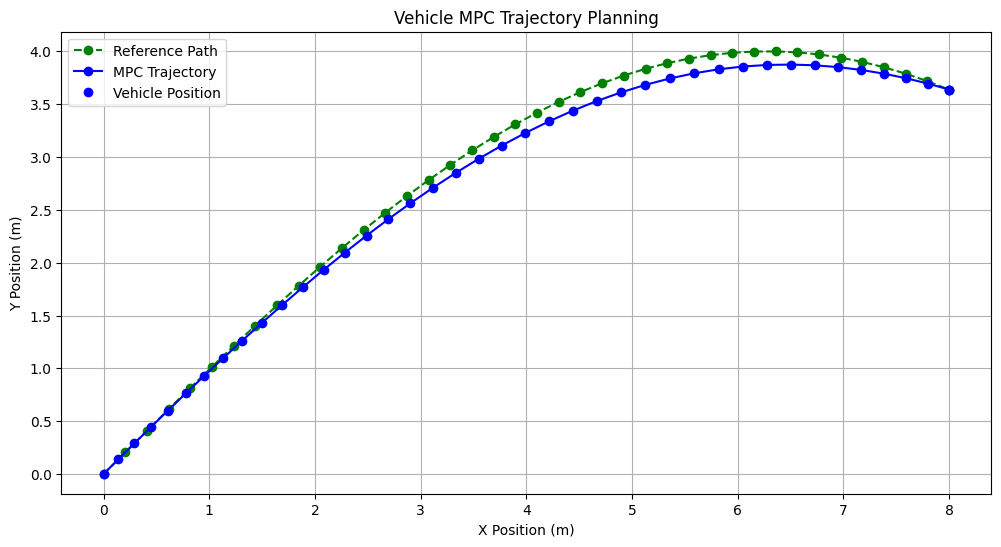

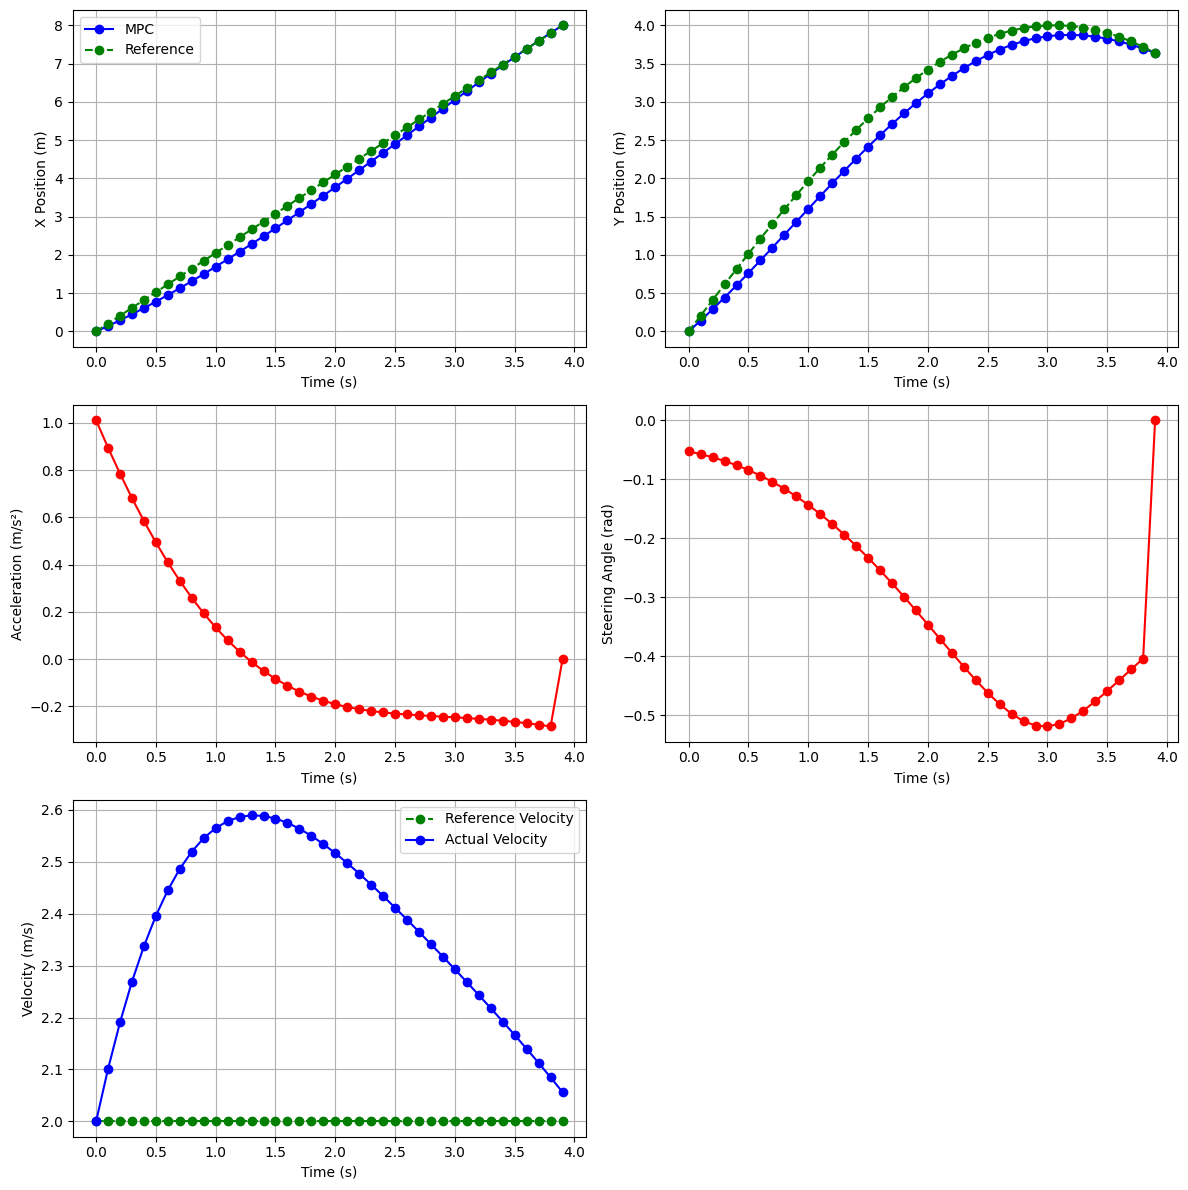

In [5]:
# Create visualization
plt.figure(figsize=(12, 6))

# Plot reference trajectory with points
plt.plot(xref_traj[:, 0], xref_traj[:, 1], 'g--o', label='Reference Path')

# Plot obstacles
for obs in obstacles:
    circle = Circle((obs[0], obs[1]), obs[2], color='red', alpha=0.5)
    plt.gca().add_patch(circle)

# Plot MPC trajectory with points
plt.plot(results['x'], results['y'], 'b-o', label='MPC Trajectory')

# Plot vehicle final position
plt.plot(results['x'][-1], results['y'][-1], 'bo', label='Vehicle Position')

# Set plot properties
plt.grid(True)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Vehicle MPC Trajectory Planning')
plt.axis('equal')
plt.show()

# Plot states, controls, and velocity as subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(12, 12))

t = np.arange(N) * 0.1  # Time vector assuming dt = 0.1

# Position plots with points
ax1.plot(t, results['x'], 'b-o', label='MPC')
ax1.plot(t, xref_traj[:, 0], 'g--o', label='Reference')
ax1.set_ylabel('X Position (m)')
ax1.set_xlabel('Time (s)')
ax1.grid(True)
ax1.legend()

ax2.plot(t, results['y'], 'b-o', label='MPC')
ax2.plot(t, xref_traj[:, 1], 'g--o', label='Reference')
ax2.set_ylabel('Y Position (m)')
ax2.set_xlabel('Time (s)')
ax2.grid(True)

# Control inputs with points
ax3.plot(t, results['u_a'], 'r-o', label='Acceleration')
ax3.set_ylabel('Acceleration (m/s²)')
ax3.set_xlabel('Time (s)')
ax3.grid(True)

ax4.plot(t, results['u_delta'], 'r-o', label='Steering Angle')
ax4.set_ylabel('Steering Angle (rad)')
ax4.set_xlabel('Time (s)')
ax4.grid(True)

# Velocity comparison with points
ax5.plot(t, xref_traj[:, 3], 'g--o', label='Reference Velocity')
ax5.plot(t, results['v'], 'b-o', label='Actual Velocity')
ax5.set_ylabel('Velocity (m/s)')
ax5.set_xlabel('Time (s)')
ax5.grid(True)
ax5.legend()

# Remove unused subplot space
fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.show()

We can now analyze the model's predicted accuracy and performance with this one solve

In [6]:
# calculate the sum of squared errors between the reference and actual x and y positions
sse_x = np.sum((results['x'] - xref_traj[:, 0])**2)
sse_y = np.sum((results['y'] - xref_traj[:, 1])**2)

# calculate the sum of squared errors between the reference and actual heading angles
sse_psi = np.sum((results['psi'] - xref_traj[:, 2])**2)

# calculate the sum of squared errors between the reference and actual velocities
sse_v = np.sum((results['v'] - xref_traj[:, 3])**2)

# calcualte the average sum of squared errors for all states
sse_x /= N
sse_y /= N
sse_psi /= N
sse_v /= N

# display in a table
print(f"{'-'*30}")
print(f"{'Sum of Squared Errors':^30}")
print(f"{'-'*30}")
print(f"{'X Position':<15} | {sse_x:>15.6f}")
print(f"{'Y Position':<15} | {sse_y:>15.6f}")
print(f"{'Heading Angle':<15} | {sse_psi:>15.6f}")
print(f"{'Velocity':<15} | {sse_v:>15.6f}")
print(f"{'-'*30}")
print("")
# display the objective value and solve time
print(f"{'Obj. Value':<15} | {results['obj_value']:>15.6f}")
print(f"{'Solve Time (s)':<15} | {results['solve_time']:>15.6f}")
print(f"{'Obs. Violations':<15} | {s_obs.records[s_obs.records['level'] > 0.001].shape[0]:>15.0f}")

------------------------------
    Sum of Squared Errors     
------------------------------
X Position      |        0.064106
Y Position      |        0.063065
Heading Angle   |        0.000897
Velocity        |        0.170935
------------------------------

Obj. Value      |       42.392801
Solve Time (s)  |        0.020000
Obs. Violations |               0


We can now do the same thing with some obstacles in the path of the reference trajectory. The vehicle should avoid the obstacles while minimizing deviation from the reference trajectory. In this iteration, we also use a prediction horizon that's shorter than the length of the total trajectory to visualize what happens.

In [7]:
def generate_reference_trajectory(N):
    """Generate a sinusoidal reference trajectory"""
    t = np.linspace(0, 20, N)
    x = t * 2  # Move forward at constant rate
    y = -4 * np.sin(0.5*t)  # Sinusoidal path
    
    # Calculate heading angle from path
    dx = np.gradient(x)
    dy = np.gradient(y)
    psi = np.arctan2(dy, dx)
    
    # Desired velocity (constant)
    v = 2.0 * np.ones_like(x)
    
    return np.column_stack((x, y, psi, v))

# Prediction horizon
N = 150

# Generate reference trajectory
xref_traj = generate_reference_trajectory(200)

# Define obstacles
obstacles = [
    [15, 2.5, 0.9],
    [5, 0, 0.9]
]

# Initial state [x, y, psi, v]
x0 = np.array([xref_traj[0][0], xref_traj[0][1], xref_traj[0][2], xref_traj[0][3]])

# Solve MPC
results = solve_mpc(x0, xref_traj, obstacles, N)

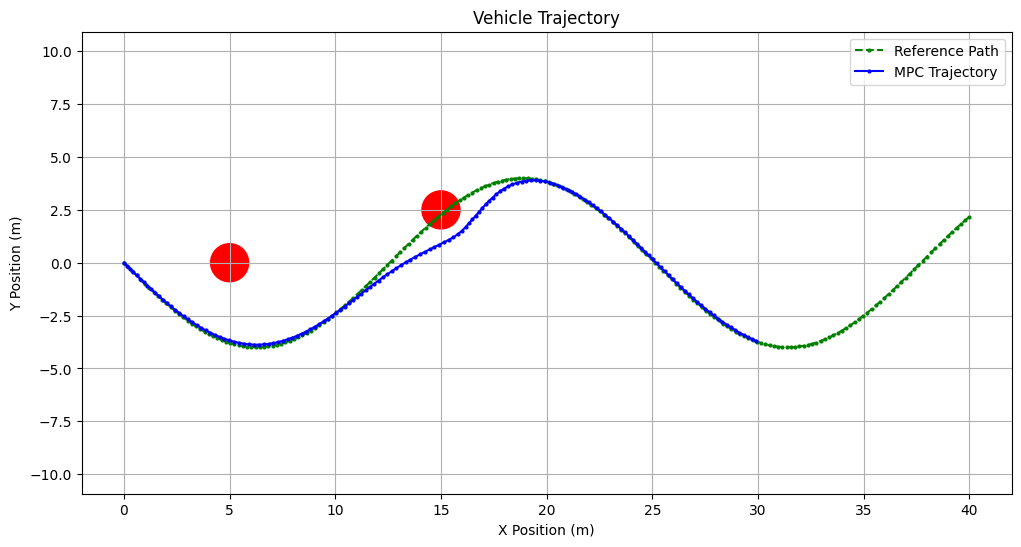

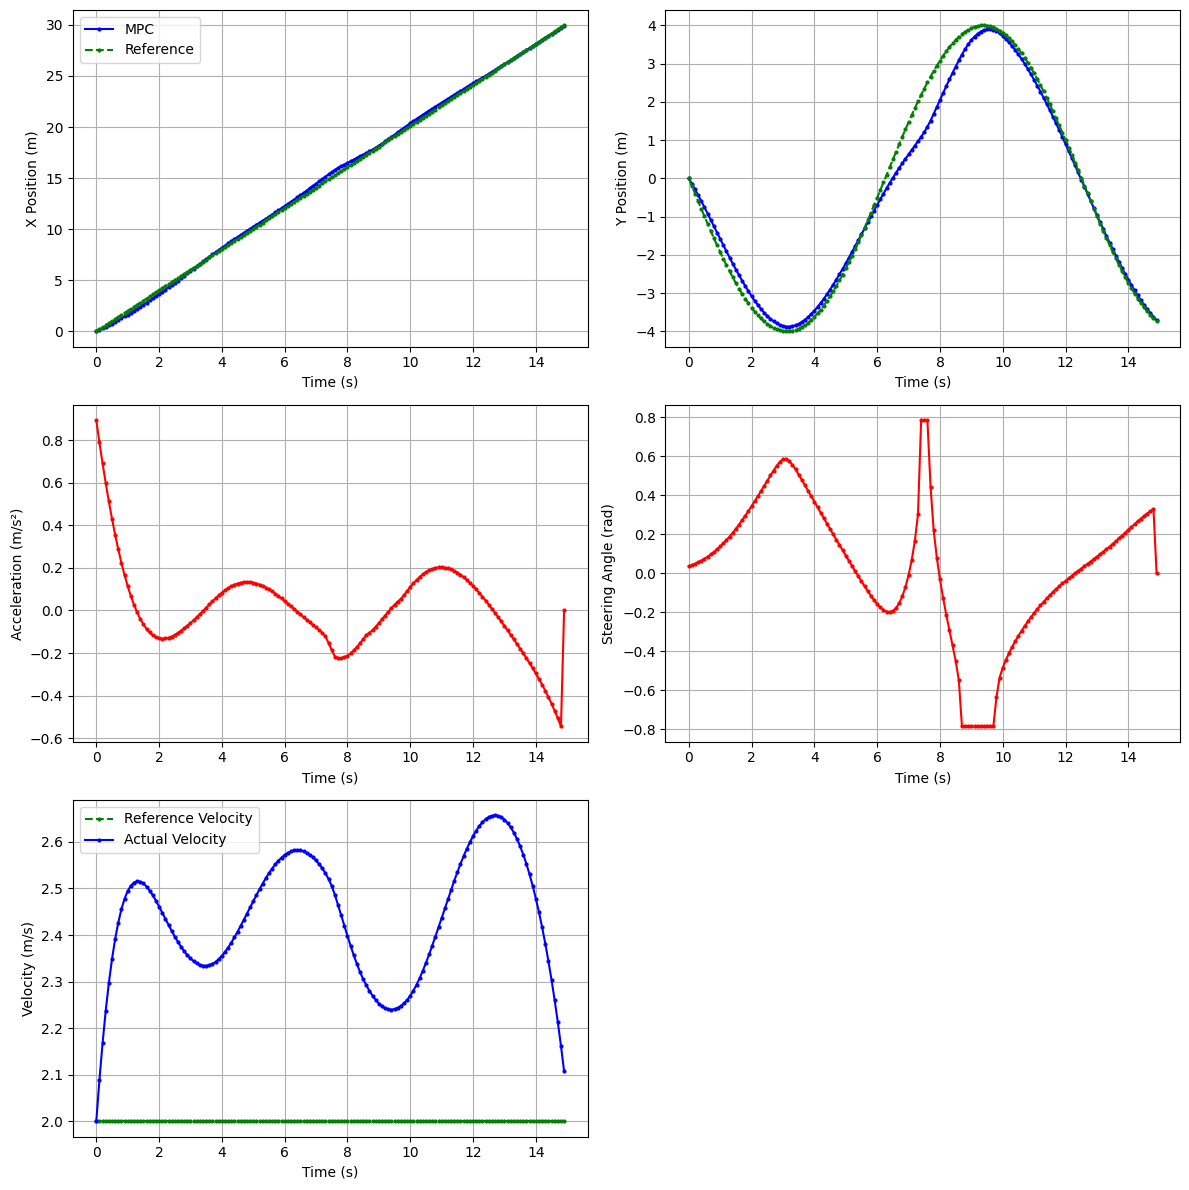

In [8]:
# Create visualization
plt.figure(figsize=(12, 6))

# Plot reference trajectory with points
plt.plot(xref_traj[:, 0], xref_traj[:, 1], 'g--o', label='Reference Path', markersize=2)

# Plot MPC trajectory with points
plt.plot(results['x'], results['y'], 'b-o', label='MPC Trajectory', markersize=2)

# Plot obstacles
for obs in obstacles:
    circle = Circle((obs[0], obs[1]), obs[2], color='red', alpha=1)
    plt.gca().add_patch(circle)

# Set plot properties
plt.grid(True)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Vehicle Trajectory')
plt.axis('equal')
plt.show()

# Plot states, controls, and velocity as subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(12, 12))

t = np.arange(N) * 0.1  # Time vector assuming dt = 0.1

# Position plots with points
ax1.plot(t, results['x'], 'b-o', label='MPC', markersize=2)
ax1.plot(t, xref_traj[:N, 0], 'g--o', label='Reference', markersize=2)
ax1.set_ylabel('X Position (m)')
ax1.set_xlabel('Time (s)')
ax1.grid(True)
ax1.legend()

ax2.plot(t, results['y'], 'b-o', label='MPC', markersize=2)
ax2.plot(t, xref_traj[:N, 1], 'g--o', label='Reference', markersize=2)
ax2.set_ylabel('Y Position (m)')
ax2.set_xlabel('Time (s)')
ax2.grid(True)

# Control inputs with points
ax3.plot(t, results['u_a'], 'r-o', label='Acceleration', markersize=2)
ax3.set_ylabel('Acceleration (m/s²)')
ax3.set_xlabel('Time (s)')
ax3.grid(True)

ax4.plot(t, results['u_delta'], 'r-o', label='Steering Angle', markersize=2)
ax4.set_ylabel('Steering Angle (rad)')
ax4.set_xlabel('Time (s)')
ax4.grid(True)

# Velocity comparison with points
ax5.plot(t, xref_traj[:N, 3], 'g--o', label='Reference Velocity', markersize=2)
ax5.plot(t, results['v'], 'b-o', label='Actual Velocity', markersize=2)
ax5.set_ylabel('Velocity (m/s)')
ax5.set_xlabel('Time (s)')
ax5.grid(True)
ax5.legend()

# Remove unused subplot space
fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.show()

Due to needing to avoid the obstacle, our error and objective values are higher. However, the model still performs well and avoids the obstacle while following the reference trajectory. Notably, it ignores any obstacles that are not in the direct path of the reference trajectory.

In [9]:
# calculate the sum of squared errors between the reference and actual x and y positions
sse_x = np.sum((results['x'] - xref_traj[:N, 0])**2)
sse_y = np.sum((results['y'] - xref_traj[:N, 1])**2)

# calculate the sum of squared errors between the reference and actual heading angles
sse_psi = np.sum((results['psi'] - xref_traj[:N, 2])**2)

# calculate the sum of squared errors between the reference and actual velocities
sse_v = np.sum((results['v'] - xref_traj[:N, 3])**2)

# calcualte the average sum of squared errors for all states
sse_x /= N
sse_y /= N
sse_psi /= N
sse_v /= N

# display in a table
print(f"{'-'*30}")
print(f"{'Sum of Squared Errors':^30}")
print(f"{'-'*30}")
print(f"{'X Position':<15} | {sse_x:>15.6f}")
print(f"{'Y Position':<15} | {sse_y:>15.6f}")
print(f"{'Heading Angle':<15} | {sse_psi:>15.6f}")
print(f"{'Velocity':<15} | {sse_v:>15.6f}")
print(f"{'-'*30}")
print("")
# display the objective value and solve time
print(f"{'Obj. Value':<15} | {results['obj_value']:>15.6f}")
print(f"{'Solve Time (s)':<15} | {results['solve_time']:>15.6f}")
print(f"{'Obs. Violations':<15} | {s_obs.records[s_obs.records['level'] > 0.001].shape[0]:>15.0f}")

------------------------------
    Sum of Squared Errors     
------------------------------
X Position      |        0.058661
Y Position      |        0.152553
Heading Angle   |        0.016385
Velocity        |        0.206605
------------------------------

Obj. Value      |      172.257176
Solve Time (s)  |        0.038000
Obs. Violations |               0


### Simulating MPC with Receding Horizon

We will now simulate actually using MPC by implementing the receding horizon, a crucial part of what gives MPC the "predictive" part of its name. We will take only the first control action returned by the solver, implement it in our simulation, update the state, and solve again for the next control action each time step. 

We'll first simulate this flow without any kind of perturbations on the state to get a baseline.

In [10]:
# Store objective value and solve times for each MPC iteration
obj_values = []
solve_times = []

# Simulation parameters
N = 20  # prediction horizon
dt = 0.1  # time step
sim_time = 25.0  # total simulation time
steps = int(sim_time/dt)

# Generate reference trajectory
t = np.linspace(0, sim_time + N*dt, steps + N)
xref = 5 * t  # Move forward at constant speed
yref = 10 * np.sin(0.5 * t)  # Sinusoidal path

# Calculate reference heading from path
dx = np.gradient(xref, dt)
dy = np.gradient(yref, dt)
psiref = np.unwrap(np.arctan2(dy, dx))
vref = np.ones_like(t) * 6  # Constant reference velocity

# Combine into reference trajectory array
xref_traj = np.column_stack((xref, yref, psiref, vref))

# Define static obstacles
obstacles = [[20, 9, 0.9]]

# Initialize state
x0 = np.array([xref[0], yref[0], psiref[0], vref[0]])

# Storage for simulation results
sim_states = []
sim_controls = []

# Simulation loop
for i in range(steps):   
    # Get reference trajectory segment for MPC horizon
    xref_horizon = xref_traj[i:i+N]
    
    # Solve MPC problem
    results = solve_mpc(x0, xref_horizon, obstacles, N)

    # Store objective value and solve time
    obj_values.append(results['obj_value'])
    solve_times.append(results['solve_time'])
    
    # Store first control input and resulting state
    sim_states.append([x0[0], x0[1], x0[2], x0[3]])
    sim_controls.append([results['u_a'][0], results['u_delta'][0]])

    # Get first control input from MPC solution
    u_a = results['u_a'][0]
    u_delta = results['u_delta'][0]
    
    # Calculate next state
    x_next = x0[0] + dt * x0[3] * np.cos(x0[2])
    y_next = x0[1] + dt * x0[3] * np.sin(x0[2])
    psi_next = x0[2] + dt * x0[3] * np.tan(u_delta) / 2.7
    v_next = x0[3] + dt * u_a

    x0 = np.array([x_next, y_next, psi_next, v_next])

We can now visualize the model's prediction by plotting
1. reference vs predicted trajectories
2. reference vs predicted velocities over time
3. steering angle and acceleration control inputs over time

We will convert this into a function we can reuse later

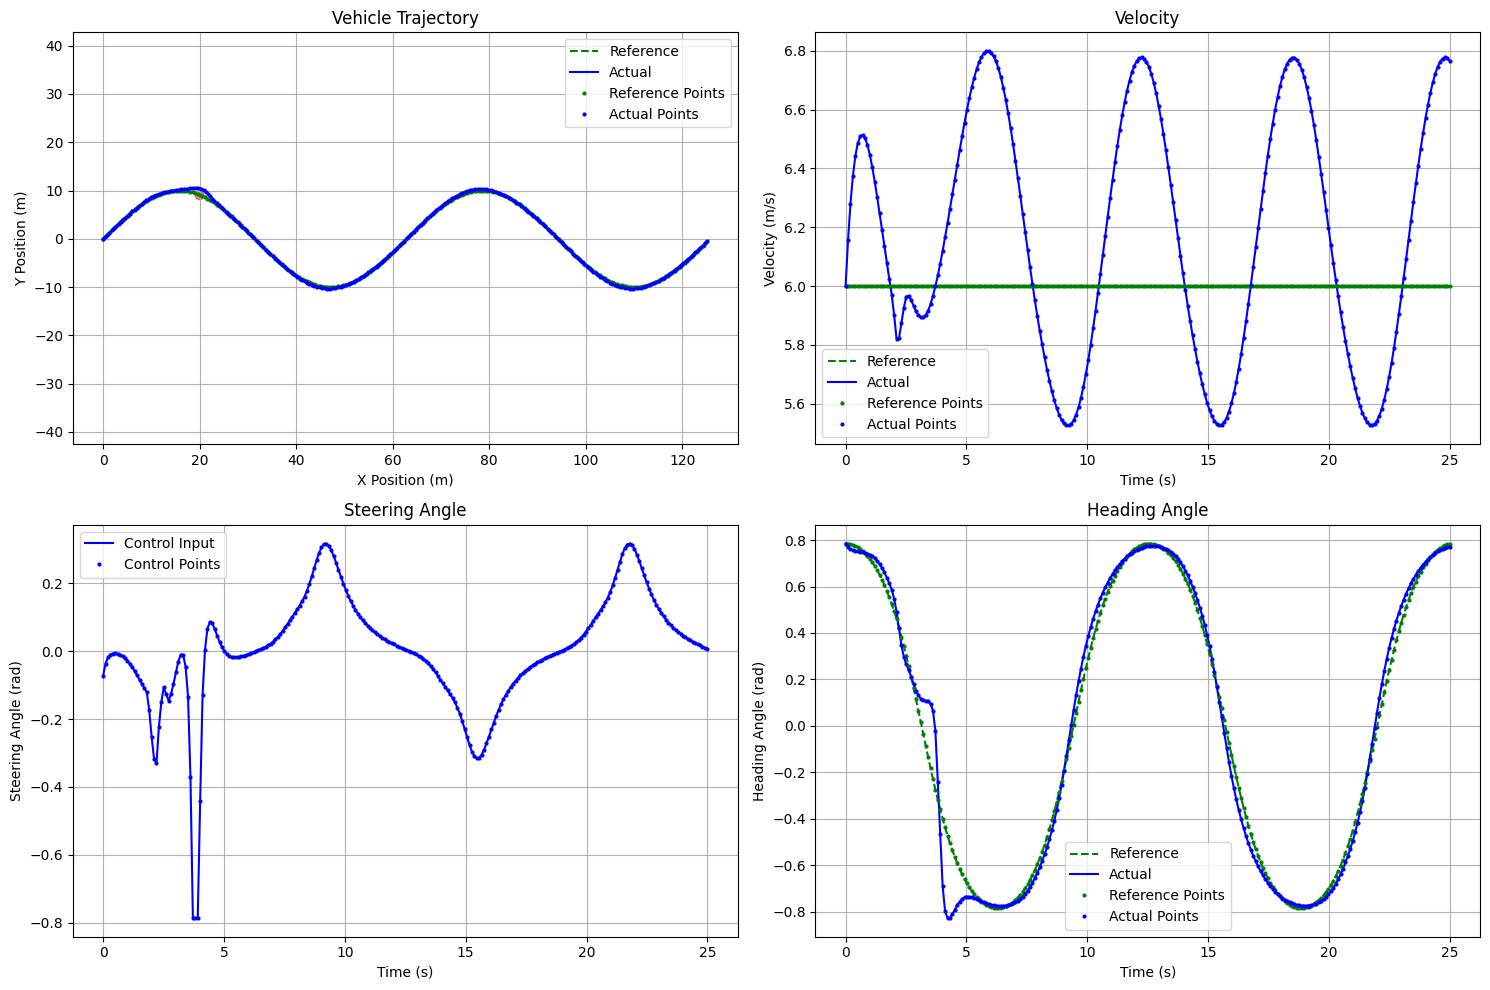

In [11]:
def visualize(sim_states, sim_controls):
    # Convert results to numpy arrays
    sim_states = np.array(sim_states)
    sim_controls = np.array(sim_controls)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot trajectory
    plt.subplot(2, 2, 1)
    plt.plot(xref[:steps], yref[:steps], 'g--', label='Reference')
    plt.plot(sim_states[:, 0], sim_states[:, 1], 'b-', label='Actual')
    # Add points
    plt.plot(xref[:steps], yref[:steps], 'g.', markersize=4, label='Reference Points')
    plt.plot(sim_states[:, 0], sim_states[:, 1], 'b.', markersize=4, label='Actual Points')
    
    # Plot obstacles
    for obs in obstacles:
        plt.gca().add_patch(Circle((obs[0], obs[1]), obs[2], color='red', alpha=0.5))
        
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title('Vehicle Trajectory')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    
    # Plot velocity
    plt.subplot(2, 2, 2)
    plt.plot(t[:steps], vref[:steps], 'g--', label='Reference')
    plt.plot(t[:steps], sim_states[:, 3], 'b-', label='Actual')
    # Add points
    plt.plot(t[:steps], vref[:steps], 'g.', markersize=4, label='Reference Points')
    plt.plot(t[:steps], sim_states[:, 3], 'b.', markersize=4, label='Actual Points')
    plt.grid(True)
    plt.legend()
    plt.title('Velocity')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    
    # Plot steering angle
    plt.subplot(2, 2, 3)
    plt.plot(t[:steps], sim_controls[:, 1], 'b-', label='Control Input')
    plt.plot(t[:steps], sim_controls[:, 1], 'b.', markersize=4, label='Control Points')
    plt.grid(True)
    plt.legend()
    plt.title('Steering Angle')
    plt.xlabel('Time (s)')
    plt.ylabel('Steering Angle (rad)')
    
    # Plot heading angle
    plt.subplot(2, 2, 4)
    plt.plot(t[:steps], psiref[:steps], 'g--', label='Reference')
    plt.plot(t[:steps], sim_states[:, 2], 'b-', label='Actual')
    # Add points
    plt.plot(t[:steps], psiref[:steps], 'g.', markersize=4, label='Reference Points')
    plt.plot(t[:steps], sim_states[:, 2], 'b.', markersize=4, label='Actual Points')
    plt.grid(True)
    plt.legend()
    plt.title('Heading Angle')
    plt.xlabel('Time (s)')
    plt.ylabel('Heading Angle (rad)')
    
    plt.tight_layout()
    plt.show()
    return [sim_states, sim_controls]

sim_states, sim_controls = visualize(sim_states, sim_controls)

We can now analyze the model's predicted accuracy and performance. We'll also put this into a function for later reuse.

In [12]:
def analyze():
    sse_x = np.sum((sim_states[:, 0] - xref[:steps])**2)
    sse_y = np.sum((sim_states[:, 1] - yref[:steps])**2)
    sse_psi = np.sum((sim_states[:, 2] - psiref[:steps])**2)
    sse_v = np.sum((sim_states[:, 3] - vref[:steps])**2)
    
    # calculate the average of each error
    sse_x /= steps
    sse_y /= steps
    sse_psi /= steps
    sse_v /= steps
    
    # calculate average objective value and solve time
    avg_obj_value = np.mean(obj_values)
    avg_solve_time = np.mean(solve_times)
    
    # display in a table
    print(f"{'-'*50}")
    print(f"{'Average Sum of Squared Errors':^50}")
    print(f"{'-'*50}")
    print(f"{'X Position (m)':<25} | {sse_x:>20.6f}")
    print(f"{'Y Position (m)':<25} | {sse_y:>20.6f}")
    print(f"{'Heading Angle (radians)':<25} | {sse_psi:>20.6f}")
    print(f"{'Velocity (m/s)':<25} | {sse_v:>20.6f}")
    print("")
    # display the average objective value and solve time
    print(f"{'-'*50}")
    print(f"{'Other Performance Metrics':^50}")
    print(f"{'-'*50}")
    print(f"{'Average Objective Value':<25} | {avg_obj_value:>20.6f}")
    print(f"{'Avgerage Solve Time (s)':<25} | {avg_solve_time:>20.6f}")
    print(f"{'Obstacle violations':<25} | {s_obs.records[s_obs.records['level'] > 0.001].shape[0]:>20.0f}")
analyze()

--------------------------------------------------
          Average Sum of Squared Errors           
--------------------------------------------------
X Position (m)            |             0.093184
Y Position (m)            |             0.078065
Heading Angle (radians)   |             0.005670
Velocity (m/s)            |             0.203632

--------------------------------------------------
            Other Performance Metrics             
--------------------------------------------------
Average Objective Value   |            22.620278
Avgerage Solve Time (s)   |             0.018116
Obstacle violations       |                    0


### Making the Model More Realistic (Simulating Environmental Perturbations)
Now we'll add some deviation between what MPC thinks will happen and what happens in simulation. This brings the simulation closer to what will happen in real life, where MPC solves the problem for the whole prediction horizon, we take the first time step control action and run it on the car, the car's state updates unpredictably in real life due to environmental factors (modelled here with some random deviation), and the MPC model is solved again on the new state data.

In [13]:
# Store objective value and solve times for each MPC iteration
obj_values = []
solve_times = []

# Process noise parameters
sigma_x = 0.02
sigma_y = 0.02
min_noise = -0.05
max_noise = 0.05

# Simulation parameters
N = 20  # prediction horizon
dt = 0.1  # time step
sim_time = 25.0  # total simulation time
steps = int(sim_time/dt)

# Generate reference trajectory
t = np.linspace(0, sim_time + N*dt, steps + N)
xref = 5 * t  # Move forward at constant speed
yref = 10 * np.sin(0.5 * t)  # Sinusoidal path

# Calculate reference heading from path
dx = np.gradient(xref, dt)
dy = np.gradient(yref, dt)
psiref = np.unwrap(np.arctan2(dy, dx))
vref = np.ones_like(t) * 6  # Constant reference velocity

# Combine into reference trajectory array
xref_traj = np.column_stack((xref, yref, psiref, vref))

# Define static obstacles
# obstacles = [[20, 9, 0.9]]
obstacles = [[40, -8, 0.9]]

# Initialize state
x0 = np.array([xref[0], yref[0], psiref[0], vref[0]])

# Storage for simulation results
sim_states = []
sim_controls = []

# Simulation loop
for i in range(steps):   
    # Get reference trajectory segment for MPC horizon
    xref_horizon = xref_traj[i:i+N]
    
    # Solve MPC problem
    results = solve_mpc(x0, xref_horizon, obstacles, N, 1)

    # Store objective value and solve time
    obj_values.append(results['obj_value'])
    solve_times.append(results['solve_time'])
    
    # Store first control input and resulting state
    sim_states.append([x0[0], x0[1], x0[2], x0[3]])
    sim_controls.append([results['u_a'][0], results['u_delta'][0]])

    # Get first control input from MPC solution
    u_a = results['u_a'][0]
    u_delta = results['u_delta'][0]
    
    # Calculate next state
    x_next = x0[0] + dt * x0[3] * np.cos(x0[2]) + np.clip(np.random.normal(0, sigma_x), min_noise, max_noise)
    y_next = x0[1] + dt * x0[3] * np.sin(x0[2]) + np.clip(np.random.normal(0, sigma_y), min_noise, max_noise)
    psi_next = x0[2] + dt * x0[3] * np.tan(u_delta) / 2.7
    v_next = x0[3] + dt * u_a

    x0 = np.array([x_next, y_next, psi_next, v_next])

We can do the same visualization as before

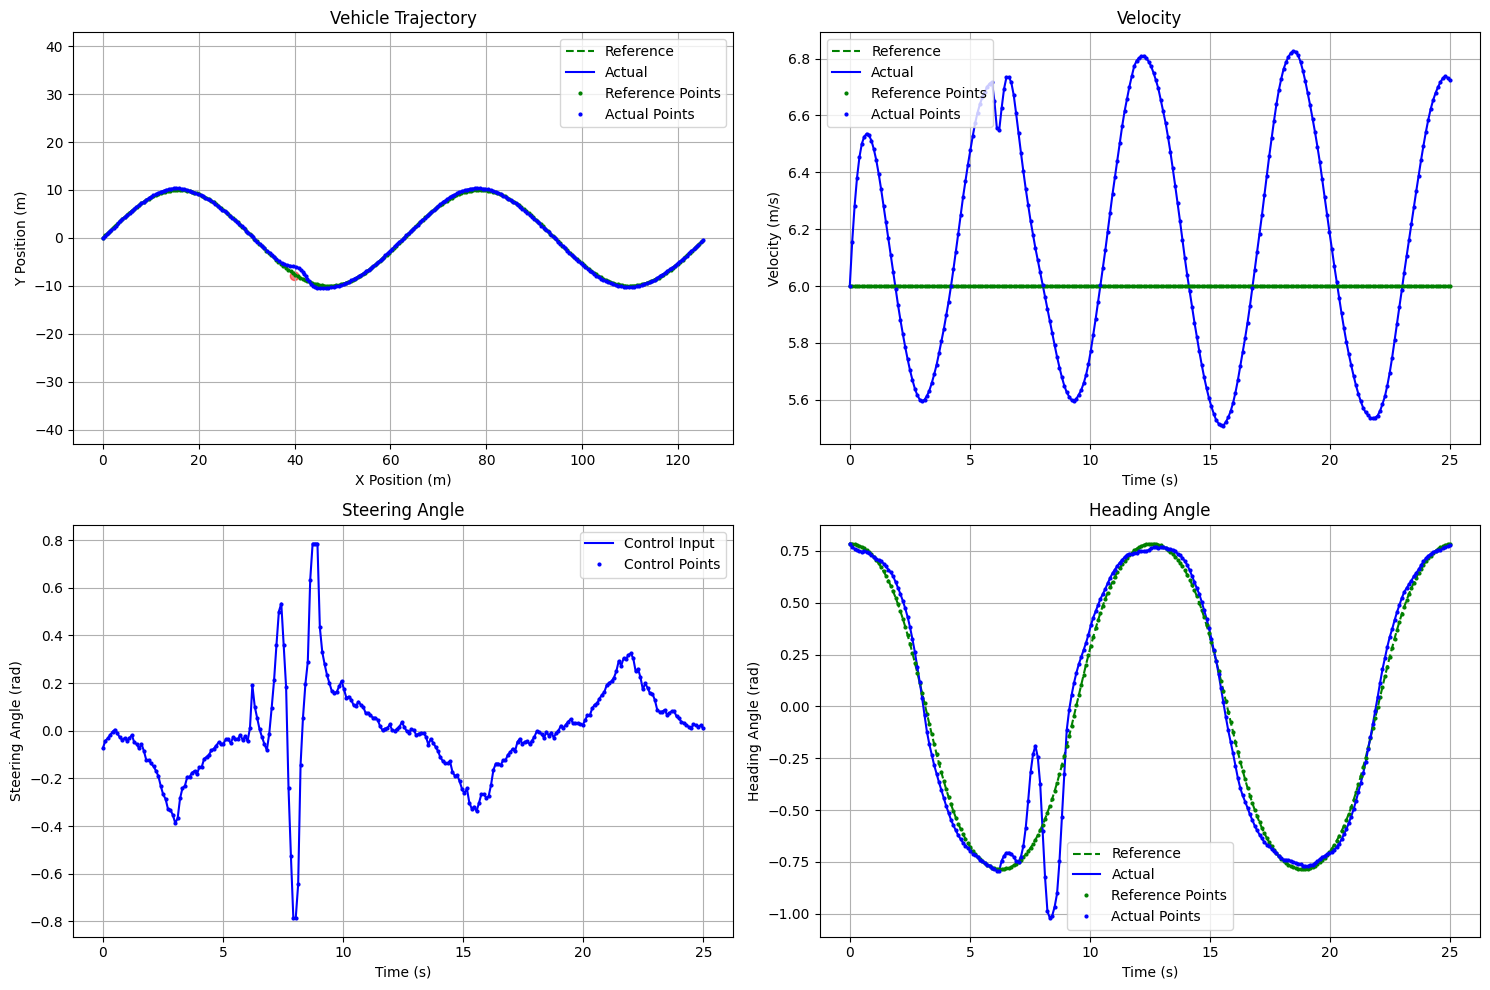

In [14]:
sim_states, sim_controls = visualize(sim_states, sim_controls)

We can now analyze the model's predicted accuracy and performance which should be worse than before due to the added noise

In [15]:
analyze()

--------------------------------------------------
          Average Sum of Squared Errors           
--------------------------------------------------
X Position (m)            |             0.082994
Y Position (m)            |             0.112185
Heading Angle (radians)   |             0.013091
Velocity (m/s)            |             0.204770

--------------------------------------------------
            Other Performance Metrics             
--------------------------------------------------
Average Objective Value   |            26.916554
Avgerage Solve Time (s)   |             0.017940
Obstacle violations       |                    0


### Simulating a More Difficult Scenario

We will now simulate a more difficult scenario where the vehicle moves through an environment with some tight left and right turns, we perturbe the state, and there are multiple obstacles.

In [16]:
# Store objective value and solve times for each MPC iteration
obj_values = []
solve_times = []

# Process noise parameters
sigma_x = 0.02
sigma_y = 0.02 
min_noise = -0.05
max_noise = 0.05

# Simulation parameter
N = 20  # prediction horizon
dt = 0.1  # time step
sim_time = 63 # total simulation time for one cycle of figure 8
steps = int(sim_time/dt)

# Figure-8 trajectory
t = np.linspace(0, sim_time + N * dt, steps + N)
xref = 35 * np.sin(0.1 * t)  # Horizontal motion
yref = 35 * np.sin(0.1 * t) * np.cos(0.1 * t)  # Vertical motion

# Calculate reference heading from path
dx = np.gradient(xref, dt)
dy = np.gradient(yref, dt)
psiref = np.unwrap(np.arctan2(dy, dx))
vref = np.ones_like(t) * 4.0  # Constant reference velocity

# Combine into reference trajectory array
xref_traj = np.column_stack((xref, yref, psiref, vref))

# Define static obstacles
obstacles = [
    [15, 14, 0.9],
    [-20, -16, 0.9]
]

# Initialize state
x0 = np.array([xref[0], yref[0], psiref[0], vref[0]])

# Storage for simulation results
sim_states = []
sim_controls = []

# Simulation loop
for i in range(steps):   
    # Get reference trajectory segment for MPC horizon
    xref_horizon = xref_traj[i:i+N]

    # Solve MPC problem
    results = solve_mpc(x0, xref_horizon, obstacles, N, 1)
    
    # Store first control input and resulting state
    sim_states.append([x0[0], x0[1], x0[2], x0[3]])
    sim_controls.append([results['u_a'][0], results['u_delta'][0]])

    # Store objective value and solve time
    obj_values.append(results['obj_value'])
    solve_times.append(results['solve_time'])

    # Get first control input from MPC solution
    u_a = results['u_a'][0]
    u_delta = results['u_delta'][0]
    
    # Calculate next state with process noise
    x_next = x0[0] + dt * x0[3] * np.cos(x0[2]) + np.clip(np.random.normal(0, sigma_x), min_noise, max_noise)
    y_next = x0[1] + dt * x0[3] * np.sin(x0[2]) + np.clip(np.random.normal(0, sigma_y), min_noise, max_noise)
    psi_next = x0[2] + dt * x0[3] * np.tan(u_delta) / 2.7
    v_next = x0[3] + dt * u_a
    
    x0 = np.array([x_next, y_next, psi_next, v_next])

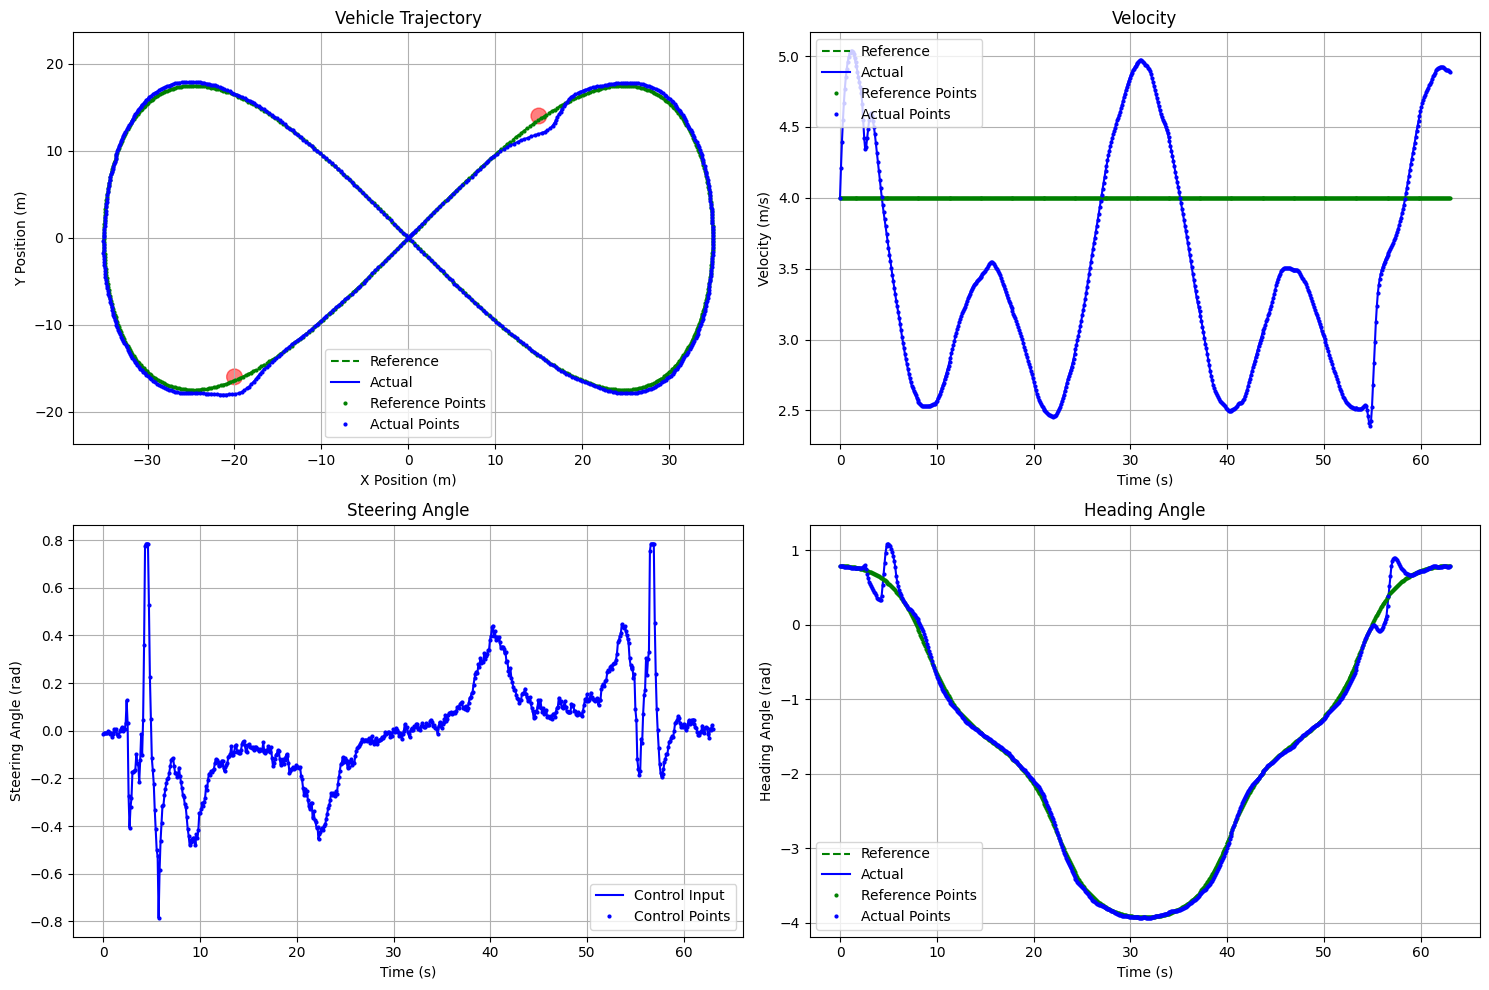

In [17]:
sim_states, sim_controls = visualize(sim_states, sim_controls)

In [18]:
analyze()

--------------------------------------------------
          Average Sum of Squared Errors           
--------------------------------------------------
X Position (m)            |             0.087858
Y Position (m)            |             0.128776
Heading Angle (radians)   |             0.010521
Velocity (m/s)            |             0.919791

--------------------------------------------------
            Other Performance Metrics             
--------------------------------------------------
Average Objective Value   |            48.902927
Avgerage Solve Time (s)   |             0.017787
Obstacle violations       |                    0


## 5. Discussion of Results

The formulated MPC model is intentionally simple, using a basic vehicle dynamics model without constraints for lane keeping, acceleration rate changes, or steering angle adjustments. It also does not leverage common trajectory metadata like curvature. This simplicity ensures that the model's solve time is efficient, averaging around 0.03 seconds per iteration. This corresponds to a control action update rate of approximately 33 Hz, suitable for real-time applications at lower speeds.

For straightforward trajectories with minimal sharp or frequent turns, the model performs adequately. However, its robustness remains a concern. To deploy the MPC controller on a real vehicle, it must reliably produce viable solutions for every iteration. While a slack variable in the obstacle avoidance constraint enhances robustness, additional edge cases could pose challenges.

This basic GAMSPy implementation demonstrates the potential of MPC as a powerful tool for autonomous vehicle control. Despite its simplicity, the model effectively handles trajectory following and obstacle avoidance. Furthermore, the model can seamlessly integrate additonal desirable constraints, such as lane keeping and dynamic obstacle avoidance, which are challenging to implement with alternative controllers like PID or Stanley.

However, adding such constraints increases problem complexity, necessitating the use of more efficient optimization frameworks like CasADi or ACADO. These tools are better suited for high-performance applications. Nevertheless, GAMS and GAMSPy remain valuable for rapid prototyping, early-stage model development, and proof-of-concept demonstrations, as shown in this project.

## 6. Further Work/Improvements

1. **Vehicle Dynamics**: The model can be improved by using a more realistic/complex vehicle dynamics
2. **More Constraints**: Constraints for lane keeping, rate of change of acceleration and rate of change of steering angle, and max/min curvature could be incorporated to improve the model's utility and performance.
3. **Robustness**: The model's robustness can be improved by proving guarantees for a viable solution to every solve iteration.
4. **Performance**: The model's performance can be improved by using a more performant and MPC optimized optimization framework like CasADi or ACADO for more complex models.
5. **Real-World Testing**: The model should eventually be tested in a real-world environment to validate its performance and accuracy.
6. **Dynamic Obstacle Avoidance**: The model can be improved to handle dynamic obstacles by changing their state each time step.
7. **Simulation**: The vehicle dynamics model used to simulate the vehicle should ideally be different and more complex than the vehicle dynamics model currently being used. A more robust and repeatable method should be used to generate test reference trajectories. Finally, a more structured and scientific method should be utilized to simulate environmental factors.